# 🧠 Facial Emotion Recognition - CNN with Attention

This notebook trains a custom CNN with spatial attention (CBAM-style) on the FER-2013 dataset.

In [6]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cpu


In [7]:

# Paths to dataset
train_dir = 'Data/train'
test_dir = 'Data/test'

# Image transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [8]:

# Spatial Attention Module (CBAM-style)
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = torch.sigmoid(self.conv(x_cat))
        return x * attention


In [9]:

# CNN with integrated spatial attention
class AttentionCNN(nn.Module):
    def __init__(self):
        super(AttentionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.attention = SpatialAttention()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # 128x128 -> 64x64 -> 32x32
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))  # First pooling
        x = self.pool(x)                      # Second pooling to get 32x32
        x = self.attention(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model, loss, optimizer
attention_model = AttentionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.001)


In [10]:

# Training loop
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    attention_model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = attention_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"[Attention CNN] Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


[Attention CNN] Epoch [1/5], Loss: 1.6879
[Attention CNN] Epoch [2/5], Loss: 1.5313
[Attention CNN] Epoch [3/5], Loss: 1.4280
[Attention CNN] Epoch [4/5], Loss: 1.3332
[Attention CNN] Epoch [5/5], Loss: 1.2356


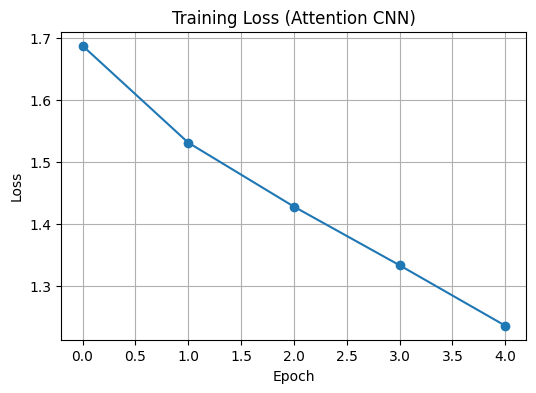

In [11]:

# Plot training loss
plt.figure(figsize=(6,4))
plt.plot(train_losses, marker='o')
plt.title("Training Loss (Attention CNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [12]:

# Evaluation on test set
attention_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = attention_model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"[Attention CNN] Test Accuracy: {accuracy:.4f}")


[Attention CNN] Test Accuracy: 0.4789


In [13]:

# Inference on a single image
test_image_path = 'my_image2.jpg'

image = Image.open(test_image_path).convert('L')
image = image.convert('RGB')
image = transform(image).unsqueeze(0).to(device)

attention_model.eval()
with torch.no_grad():
    output = attention_model(image)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f"Predicted Emotion: {predicted_class}")


Predicted Emotion: happy
